# Introduction

This notebook demonstrates hybrid cnn with one layer of quantum for binary classification problem using eurosat dataset.

# Runtime req

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
!pip install -q torch
!pip install -q matplotlib
!pip install -q visualkeras
!pip install -q qiskit
!pip install pylatexenc
!pip install torchsummary

!unzip -q "/content/drive/MyDrive/colab_notebooks/IITD-QML/EuroSAT_RGB.zip"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 11.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 72.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 87.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [14]:
import qiskit
import sys
import os
import glob
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from qiskit import execute
from qiskit.circuit import Parameter,ControlledGate
from qiskit import Aer
import random
import time
from torchsummary import summary
from collections import defaultdict

import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline

from qiskit import *
provider = qiskit
backend = Aer.get_backend("aer_simulator", device="GPU")


## GPU and CPU detection choice

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Dataset handling for loading, splitting, training.

The following section has the utilities required for operating with the data.
- Detect list of classes from the dataset root directory provided ( inside the constructor )
- Load path labels, ( image paths and labels per class ) and shuffle the data set to generate randomness.
- Provide a generator which can be provided into the torch circuit with random data set selection insde the training or test data set.



In [16]:
import glob
import os
import numpy as np
import random

class DatasetHandler:
    def __init__(self, ds_root_path):
        print ('Datahandler init -> ', ds_root_path)
        self.dataset_path = ds_root_path
        self.classes = glob.glob(os.path.join(ds_root_path, '*'))
        self.classes_dict = {}
        for c, i in zip(self.classes, range(len(self.classes))):
          self.classes_dict[c] = i
        self.dataset_mixer = 0
        self.dataset_mixer_val = 0
        self.img_cache = {}
        self.img_cache_val = {}

    def print_classes(self):
        print('Classes in the path: ')
        for i,c in enumerate(self.classes):
            print(i, ' ->', c)

    def load_paths_labels(self, root, classes):
        imgs_path = []
        imgs_label = []

        for clss in classes:
            for path in glob.glob(os.path.join(root, clss+'/*')):
              imgs_path.append(path)
              imgs_label.append(self.classes_dict[clss])

        dataset = list(zip(imgs_path, imgs_label))
        random.shuffle(dataset)
        paths, labels = zip(*dataset)
        return np.array(paths), np.array(labels)

    # Split the dataset into training and validation dataset
    def train_validation_split(self, images, labels, split_factor = 0.2):
        val_size = int(len(images)*split_factor)
        train_size = int(len(images) - val_size)
        return images[0:train_size], labels[0:train_size, ...], images[train_size:train_size+val_size], labels[train_size:train_size+val_size, ...]

    # Data genertor: given images paths and images labels yield a batch of images and labels
    def cnn_data_loader(self, imgs_path, imgs_label, batch_size = 1, img_shape = (64, 64, 3), vald=False):
      # Initialize the vectors to be yield
      batch_in = np.zeros((batch_size, img_shape[2], img_shape[0], img_shape[1]))
      batch_out = np.zeros((batch_size))

      from collections import defaultdict

      while True:
        for i in range(batch_size):
          index = self.dataset_mixer
          self.dataset_mixer += 1
          if self.dataset_mixer >= len(imgs_path):
            self.dataset_mixer = 0

          if index not in self.img_cache:
            self.img_cache[index] = np.transpose(plt.imread(imgs_path[index])/255.0)

          batch_in[i, ...] = self.img_cache[index]
          batch_out[i] = imgs_label[index]
          yield  torch.tensor(batch_in).type(torch.float).to(device),  torch.tensor(batch_out).type(torch.float).to(device)

    # Data genertor: given images paths and images labels yield a batch of images and labels
    def cnn_val_loader(self, imgs_path, imgs_label, batch_size = 1, img_shape = (64, 64, 3), vald=False):
      # Initialize the vectors to be yield
      batch_in = np.zeros((batch_size, img_shape[2], img_shape[0], img_shape[1]))
      batch_out = np.zeros((batch_size))

      from collections import defaultdict

      while True:
        for i in range(batch_size):
          index = self.dataset_mixer_val
          self.dataset_mixer_val += 1
          if self.dataset_mixer_val >= len(imgs_path):
            self.dataset_mixer_val = 0

          if index not in self.img_cache_val:
            self.img_cache_val[index] = np.transpose(plt.imread(imgs_path[index])/255.0)

          batch_in[i, ...] = self.img_cache_val[index]
          batch_out[i] = imgs_label[index]
          yield  torch.tensor(batch_in).type(torch.float).to(device),  torch.tensor(batch_out).type(torch.float).to(device)



In [17]:
sys.path.append('/content/drive/MyDrive/colab_notebooks/IITD-QML/')
dataset_root_path = '/content/EuroSAT_RGB'


In [18]:
handler = DatasetHandler(dataset_root_path)
imgs_path, imgs_label = handler.load_paths_labels(dataset_root_path, handler.classes)
print('Dataset images:', len(imgs_path), 'Dataset labels:', len(imgs_label))
print('Dataset sample ->', imgs_path[0], imgs_label[0])

Datahandler init ->  /content/EuroSAT_RGB
Dataset images: 27000 Dataset labels: 27000
Dataset sample -> /content/EuroSAT_RGB/Residential/Residential_205.jpg 4


In [19]:
train_imgs, train_labels, val_images, val_labels = handler.train_validation_split(imgs_path, imgs_label, split_factor=0.2)
print('X_train shape:', train_imgs.shape, 'Y_train shape:', train_labels.shape)
print('  X_val shape: ', val_images.shape, '  Y_val shape: ', val_labels.shape)

X_train shape: (21600,) Y_train shape: (21600,)
  X_val shape:  (5400,)   Y_val shape:  (5400,)


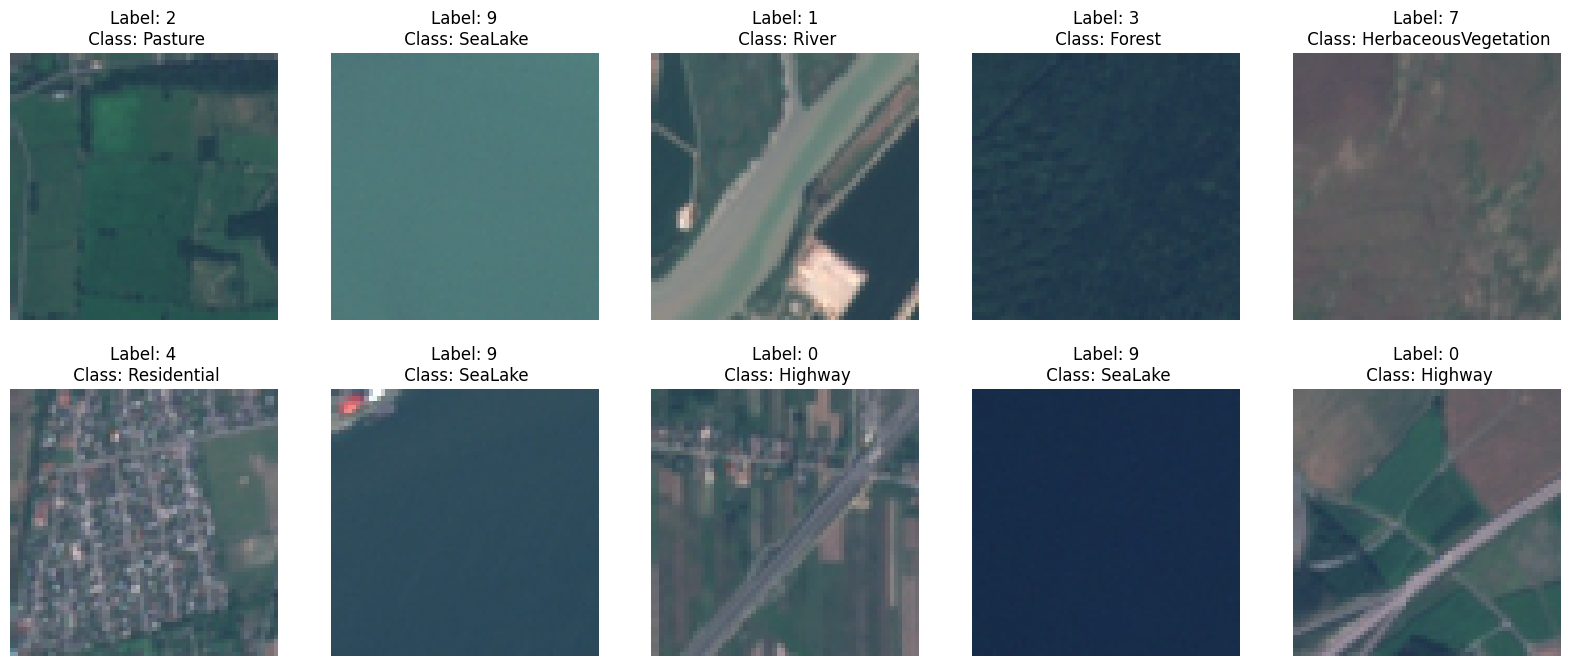

In [20]:
def plotDataset(images, labels, classes, columns, rows):
    fig, axes = plt.subplots(nrows = rows, ncols = columns, figsize = (columns*4,rows*4))
    for x in range(columns):
        for y in range(rows):
            index = random.randint(0, len(images)-1)

            axes[y,x].imshow(plt.imread(images[index]))
            axes[y,x].set_title('Label: ' + str(labels[index]) +
                                '\n Class: ' + classes[labels[index]].split('/')[-1])
            axes[y,x].axis(False)

    plt.show()
plotDataset(train_imgs, train_labels, handler.classes, columns = 5, rows = 2)

# Classical multi-class classification CNN

In [21]:
!pip install torchview

# Quantum classification layer.

In [23]:
NUM_QUBITS = 4
NUM_SHOTS = 750
SHIFT = np.pi/4
LEARNING_RATE = 0.0001
MOMENTUM = 0.5

SIMULATOR = Aer.get_backend('aer_simulator')

In [24]:
handler = DatasetHandler(dataset_root_path)
imgs_path, imgs_label = handler.load_paths_labels(dataset_root_path, handler.classes)
print('Dataset images:', len(imgs_path), 'Dataset labels:', len(imgs_label))
print('Dataset sample ->', imgs_path[0], imgs_label[0])

Datahandler init ->  /content/EuroSAT_RGB
Dataset images: 27000 Dataset labels: 27000
Dataset sample -> /content/EuroSAT_RGB/Pasture/Pasture_1907.jpg 2


In [13]:
train_imgs, train_labels, val_images, val_labels = handler.train_validation_split(imgs_path, imgs_label, split_factor=0.2)
print('X_train shape:', train_imgs.shape, 'Y_train shape:', train_labels.shape)
print('  X_val shape: ', val_images.shape, '  Y_val shape: ', val_labels.shape)

X_train shape: (21600,) Y_train shape: (21600,)
  X_val shape:  (5400,)   Y_val shape:  (5400,)


## Quantum circuit to be embedded into the layer.

The following circuit code below, generates a bell circuit of 4 Qubits for usage in the CNN down under.
4 Qubit circuit generates, 16 states which can be used as inputs to the state next.
The previous layer in quantum has 4 as outputs which are connected to the QC circuit as inputs.

In [25]:
import itertools
def create_QC_OUTPUTS():
    measurements = list(itertools.product([0, 1], repeat=NUM_QUBITS))
    return [''.join([str(bit) for bit in measurement]) for measurement in measurements]

QC_OUTPUTS = create_QC_OUTPUTS()
print(QC_OUTPUTS)

['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']


In [26]:
class QCNeuron():
    def __init__(self, n_qubits, backend, shots):
        self.qc = QuantumCircuit(n_qubits)
        self.n_qubits = n_qubits
        self.thetas = {k : Parameter('Theta'+str(k)) for k in range(self.n_qubits)}

        self.qc.h(0)
        self.qc.cx(1, 0)
        self.qc.cx(2, 1)
        self.qc.cx(3, 2)

        self.qc.barrier()

        for k in range(0, 4):
            self.qc.ry(self.thetas[k], k)

        self.qc.barrier()

        self.qc.cx(3, 2)
        self.qc.cx(2, 1)
        self.qc.cx(1, 0)
        self.qc.h(0)

        self.qc.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots

        self.tqc = transpile(self.qc, backend=self.backend)


    def N_qubit_expectation_Z(self,counts, shots, nr_qubits):
        expects = np.zeros(len(QC_OUTPUTS))
        for k in range(len(QC_OUTPUTS)):
            key = QC_OUTPUTS[k]
            perc = counts.get(key, 0)/shots
            expects[k] = perc
        return expects

    def run(self, i):
        params = i.cpu().data.numpy()
        parameters = {}

        for k in range(self.n_qubits):
          parameters[self.thetas[k]] = params[k].item()

        qobj = assemble(self.tqc,
                        shots=self.shots,
                        parameter_binds = [parameters])

        job = self.backend.run(qobj)
        res =  self.N_qubit_expectation_Z(job.result().get_counts(), self.shots, self.n_qubits)
        return res

## Sample QC circuit with 4 parameters is below.

In [16]:
circuit = QCNeuron(NUM_QUBITS, Aer.get_backend('aer_simulator', device="GPU"), NUM_SHOTS)
circuit.qc.draw(fold=2000)

┌───┐┌───┐           ░ ┌────────────┐ ░           ┌───┐┌───┐ ░ ┌─┐         
   q_0: ┤ H ├┤ X ├───────────░─┤ Ry(Theta0) ├─░───────────┤ X ├┤ H ├─░─┤M├─────────
        └───┘└─┬─┘┌───┐      ░ ├────────────┤ ░      ┌───┐└─┬─┘└───┘ ░ └╥┘┌─┐      
   q_1: ───────■──┤ X ├──────░─┤ Ry(Theta1) ├─░──────┤ X ├──■────────░──╫─┤M├──────
                  └─┬─┘┌───┐ ░ ├────────────┤ ░ ┌───┐└─┬─┘           ░  ║ └╥┘┌─┐   
   q_2: ────────────■──┤ X ├─░─┤ Ry(Theta2) ├─░─┤ X ├──■─────────────░──╫──╫─┤M├───
                       └─┬─┘ ░ ├────────────┤ ░ └─┬─┘                ░  ║  ║ └╥┘┌─┐
   q_3: ─────────────────■───░─┤ Ry(Theta3) ├─░───■──────────────────░──╫──╫──╫─┤M├
                             ░ └────────────┘ ░                      ░  ║  ║  ║ └╥┘
meas: 4/════════════════════════════════════════════════════════════════╩══╩══╩══╩═
                                                                        0  1  2  3

In [17]:
np_array = np.array([5, 7, 1, 2])

# Convert Numpy array to torch.Tensor
tensor_a = torch.from_numpy(np_array)

circuit.run(tensor_a)

<ipython-input-15-5540ea416a65>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


array([0.12666667, 0.06      , 0.028     , 0.008     , 0.008     ,
       0.00266667, 0.03333333, 0.02266667, 0.08933333, 0.04533333,
       0.01333333, 0.004     , 0.04266667, 0.03333333, 0.31733333,
       0.16533333])

## Quantum neural network hidden layer

In [27]:
class QuantumLayer(Function):
    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'qc'):
            ctx.qc = QCNeuron(NUM_QUBITS, SIMULATOR, shots=NUM_SHOTS)

        exp_value = ctx.qc.run(i)
        result = torch.tensor([exp_value]).to(device)
        ctx.save_for_backward(result, i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        forward_tensor, i = ctx.saved_tensors
        input_numbers = i
        gradients = torch.Tensor()

        for k in range(NUM_QUBITS):
            shift_right = input_numbers.detach().clone()
            shift_right[k] = shift_right[k] + SHIFT
            shift_left = input_numbers.detach().clone()
            shift_left[k] = shift_left[k] - SHIFT

            expectation_right = ctx.qc.run(shift_right)
            expectation_left  = ctx.qc.run(shift_left)

            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients = torch.cat((gradients, gradient.float()))

        result = torch.Tensor(gradients).to(device)

        return (result.float() * grad_output.float()).T

In [28]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)

        self.fc1 = nn.Linear(2304, 4)
        self.qc = QuantumLayer.apply
        self.fc2 = nn.Linear(16, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))

        x = x.view(-1, 2304)
        x = self.fc1(x)
        x = np.pi*torch.tanh(x)

        x = self.qc(x[0]) # QUANTUM LAYER
        x = F.relu(x)
        x = self.fc2(x.float())
        x = F.softmax(x, 1)
        return x


    def predict(self, x):
        # apply softmax
        pred = self.forward(x)
#         print(pred)
        ans = torch.argmax(pred[0]).item()
        return torch.tensor(ans)

hybrid_network = Net().to(device)
optimizer = optim.Adam(hybrid_network.parameters(), lr=0.0002)

In [35]:
hybrid_network = Net().to(device)
optimizer = optim.Adam(hybrid_network.parameters(), lr=0.0002)

checkpoint = torch.load('/content/drive/MyDrive/colab_notebooks/IITD-QML/model-multi-class-hybrid-lenet5-modif.pt')
hybrid_network.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

hybrid_network.eval()
# - or -
hybrid_network.train()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2304, out_features=4, bias=True)
  (fc2): Linear(in_features=16, out_features=10, bias=True)
)

In [29]:
summary(hybrid_network, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 62, 62]             448
            Conv2d-2           [-1, 32, 29, 29]           4,640
            Conv2d-3           [-1, 64, 12, 12]          18,496
            Linear-4                    [-1, 4]           9,220
            Linear-5                   [-1, 10]             170
Total params: 32,974
Trainable params: 32,974
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.74
Params size (MB): 0.13
Estimated Total Size (MB): 0.92
----------------------------------------------------------------


<ipython-input-26-5540ea416a65>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)
<ipython-input-27-2fcf0791b6ac>:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  result = torch.tensor([exp_value]).to(device)


In [30]:
train_loss_list = []
val_loss_list = []
epochs = 20

loss_func = nn.CrossEntropyLoss()

for epoch in range(epochs):
  train_loader = iter(handler.cnn_data_loader(train_imgs, train_labels, batch_size = 1, img_shape = (64,64,3)))
  test_loader = iter(handler.cnn_val_loader(val_images, val_labels, batch_size = 1, img_shape = (64,64,3)))
  total_loss = []
  for batch_idx in range(len(train_labels)):
    data, target = next(train_loader)
    # print(batch_idx)
    optimizer.zero_grad()
    # Forward pass
    output = hybrid_network(data)
    target = target.type(torch.LongTensor).to(device)
    # Calculating loss
    loss = loss_func(output, target)
    # Backward pass
    loss.backward()
    # Optimize the weights
    optimizer.step()

    total_loss.append(loss.item())

    print('\rEpoch %d ~ Batch %d (%d) ~ Loss %f ' % (epoch, batch_idx, len(train_imgs)-1, loss.item()), end='\t\t')


  with torch.no_grad():
    val_loss = []
    targets = []
    predictions = []
    for batch_idx in range(len(val_images)):
      data, target = next(test_loader)
      output = hybrid_network(data)
      target = target.type(torch.LongTensor).to(device)

      loss = loss_func(output, target)
      val_loss.append(loss.item())

      targets.append(target.item())

      predictions.append(hybrid_network.predict(data).item())


    train_loss_list.append(sum(total_loss)/len(total_loss))
    val_loss_list.append(sum(val_loss)/len(val_loss))

    print('Training [{:.0f}%]\t Training Loss: {:.4f} Validation Loss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, train_loss_list[-1], val_loss_list[-1]))

    print(confusion_matrix(targets, predictions,normalize='true'))
    print(classification_report(targets, predictions, target_names=handler.classes, digits=4, labels=np.unique(predictions)))

    torch.save({
            'epoch': epoch,
            'model_state_dict': hybrid_network.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss_list[-1],
            }, '/content/drive/MyDrive/colab_notebooks/IITD-QML/model-multi-class-hybrid-lenet5-modif.pt')


<ipython-input-26-5540ea416a65>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 0 ~ Batch 298 (21599) ~ Loss 2.308678 		

KeyboardInterrupt: ignored

In [22]:
handler = DatasetHandler(dataset_root_path)
imgs_path, imgs_label = handler.load_paths_labels(dataset_root_path, handler.classes)
train_imgs, train_labels, val_images, val_labels = handler.train_validation_split(imgs_path, imgs_label, split_factor=0.2)

Datahandler init ->  /content/EuroSAT_RGB


In [23]:
handler.classes

['/content/EuroSAT_RGB/Highway',
 '/content/EuroSAT_RGB/River',
 '/content/EuroSAT_RGB/Pasture',
 '/content/EuroSAT_RGB/Forest',
 '/content/EuroSAT_RGB/Residential',
 '/content/EuroSAT_RGB/AnnualCrop',
 '/content/EuroSAT_RGB/PermanentCrop',
 '/content/EuroSAT_RGB/HerbaceousVegetation',
 '/content/EuroSAT_RGB/Industrial',
 '/content/EuroSAT_RGB/SeaLake']

In [36]:
cm = None

for epoch in range(5):
  train_loader = iter(handler.cnn_data_loader(train_imgs, train_labels, batch_size = 1, img_shape = (64,64,3)))
  test_loader = iter(handler.cnn_val_loader(val_images, val_labels, batch_size = 1, img_shape = (64,64,3)))
  total_loss = []
  for batch_idx in range(len(train_labels)):
    data, target = next(train_loader)
    # print(batch_idx)
    optimizer.zero_grad()
    # Forward pass
    output = hybrid_network(data)
    target = target.type(torch.LongTensor).to(device)
    # Calculating loss
    loss = loss_func(output, target)
    # Backward pass
    loss.backward()
    # Optimize the weights
    optimizer.step()

    total_loss.append(loss.item())

    print('\rEpoch %d ~ Batch %d (%d) ~ Loss %f ' % (epoch, batch_idx, len(train_imgs)-1, loss.item()), end='\t\t')


  with torch.no_grad():
    val_loss = []
    targets = []
    predictions = []
    for batch_idx in range(len(val_images)):
      data, target = next(test_loader)
      output = hybrid_network(data)
      target = target.type(torch.LongTensor).to(device)

      loss = loss_func(output, target)
      val_loss.append(loss.item())

      targets.append(target.item())

      predictions.append(hybrid_network.predict(data).item())


    train_loss_list.append(sum(total_loss)/len(total_loss))
    val_loss_list.append(sum(val_loss)/len(val_loss))

    print('Training [{:.0f}%]\t Training Loss: {:.4f} Validation Loss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, train_loss_list[-1], val_loss_list[-1]))

    cm = confusion_matrix(targets, predictions,normalize='true')
    print(classification_report(targets, predictions, target_names=handler.classes, digits=4, labels=np.unique(predictions)))

    torch.save({
            'epoch': epoch,
            'model_state_dict': hybrid_network.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss_list[-1],
            }, '/content/drive/MyDrive/colab_notebooks/IITD-QML/model-multi-class-hybrid-lenet5-modif.pt')


<ipython-input-26-5540ea416a65>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 0 ~ Batch 21599 (21599) ~ Loss 1.465734 		Training [5%]	 Training Loss: 1.6185 Validation Loss: 1.5932
                                           precision    recall  f1-score   support

             /content/EuroSAT_RGB/Highway     0.8825    0.7807    0.8285       529
               /content/EuroSAT_RGB/River     0.9004    0.8828    0.8915       512
             /content/EuroSAT_RGB/Pasture     0.7696    0.8372    0.8020       387
              /content/EuroSAT_RGB/Forest     0.9743    0.9332    0.9533       569
         /content/EuroSAT_RGB/Residential     0.9552    0.9904    0.9725       625
          /content/EuroSAT_RGB/AnnualCrop     0.8057    0.9240    0.8608       579
       /content/EuroSAT_RGB/PermanentCrop     0.7579    0.6965    0.7259       481
/content/EuroSAT_RGB/HerbaceousVegetation     0.8786    0.8482    0.8631       606
          /content/EuroSAT_RGB/Industrial     0.9106    0.9607    0.9350       509
             /content/EuroSAT_RGB/SeaLake     0.9762    0.95

<ipython-input-26-5540ea416a65>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 1 ~ Batch 21599 (21599) ~ Loss 1.465437 		Training [10%]	 Training Loss: 1.6081 Validation Loss: 1.6249
                                           precision    recall  f1-score   support

             /content/EuroSAT_RGB/Highway     0.8581    0.7543    0.8028       529
               /content/EuroSAT_RGB/River     0.8196    0.8965    0.8563       512
             /content/EuroSAT_RGB/Pasture     0.7529    0.8269    0.7882       387
              /content/EuroSAT_RGB/Forest     0.9748    0.8155    0.8880       569
         /content/EuroSAT_RGB/Residential     0.9591    0.9744    0.9667       625
          /content/EuroSAT_RGB/AnnualCrop     0.7078    0.9119    0.7970       579
       /content/EuroSAT_RGB/PermanentCrop     0.7286    0.6029    0.6598       481
/content/EuroSAT_RGB/HerbaceousVegetation     0.9051    0.7558    0.8237       606
          /content/EuroSAT_RGB/Industrial     0.8891    0.9607    0.9235       509
             /content/EuroSAT_RGB/SeaLake     0.9077    0.9

<ipython-input-26-5540ea416a65>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 2 ~ Batch 21599 (21599) ~ Loss 1.464347 		Training [15%]	 Training Loss: 1.6025 Validation Loss: 1.6107
                                           precision    recall  f1-score   support

             /content/EuroSAT_RGB/Highway     0.8653    0.7410    0.7984       529
               /content/EuroSAT_RGB/River     0.8583    0.8281    0.8429       512
             /content/EuroSAT_RGB/Pasture     0.6841    0.8450    0.7561       387
              /content/EuroSAT_RGB/Forest     0.9686    0.9227    0.9451       569
         /content/EuroSAT_RGB/Residential     0.9742    0.9680    0.9711       625
          /content/EuroSAT_RGB/AnnualCrop     0.7698    0.9240    0.8399       579
       /content/EuroSAT_RGB/PermanentCrop     0.6878    0.6778    0.6827       481
/content/EuroSAT_RGB/HerbaceousVegetation     0.8996    0.7838    0.8377       606
          /content/EuroSAT_RGB/Industrial     0.8879    0.9646    0.9247       509
             /content/EuroSAT_RGB/SeaLake     0.9769    0.9

<ipython-input-26-5540ea416a65>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 3 ~ Batch 21599 (21599) ~ Loss 1.463880 		Training [20%]	 Training Loss: 1.5935 Validation Loss: 1.6135
                                           precision    recall  f1-score   support

             /content/EuroSAT_RGB/Highway     0.8453    0.7543    0.7972       529
               /content/EuroSAT_RGB/River     0.8380    0.8184    0.8281       512
             /content/EuroSAT_RGB/Pasture     0.7396    0.7778    0.7582       387
              /content/EuroSAT_RGB/Forest     0.9735    0.9033    0.9371       569
         /content/EuroSAT_RGB/Residential     0.9590    0.9728    0.9658       625
          /content/EuroSAT_RGB/AnnualCrop     0.7702    0.9206    0.8387       579
       /content/EuroSAT_RGB/PermanentCrop     0.6986    0.7277    0.7128       481
/content/EuroSAT_RGB/HerbaceousVegetation     0.8895    0.7706    0.8258       606
          /content/EuroSAT_RGB/Industrial     0.8879    0.9332    0.9100       509
             /content/EuroSAT_RGB/SeaLake     0.9571    0.9

<ipython-input-26-5540ea416a65>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 4 ~ Batch 21599 (21599) ~ Loss 1.465518 		Training [25%]	 Training Loss: 1.5878 Validation Loss: 1.6065
                                           precision    recall  f1-score   support

             /content/EuroSAT_RGB/Highway     0.8805    0.7524    0.8114       529
               /content/EuroSAT_RGB/River     0.9202    0.8105    0.8619       512
             /content/EuroSAT_RGB/Pasture     0.7420    0.8398    0.7879       387
              /content/EuroSAT_RGB/Forest     0.9327    0.9262    0.9295       569
         /content/EuroSAT_RGB/Residential     0.9179    0.9840    0.9498       625
          /content/EuroSAT_RGB/AnnualCrop     0.7909    0.9016    0.8426       579
       /content/EuroSAT_RGB/PermanentCrop     0.7578    0.6570    0.7038       481
/content/EuroSAT_RGB/HerbaceousVegetation     0.8242    0.8432    0.8336       606
          /content/EuroSAT_RGB/Industrial     0.8739    0.9528    0.9117       509
             /content/EuroSAT_RGB/SeaLake     0.9825    0.9

In [44]:
# torch.save(hybrid_network.state_dict(), '/content/drive/MyDrive/colab_notebooks/IITD-QML/model-multi-class-hybrid-lenet5-modif.pt')

In [37]:
hybrid_network

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2304, out_features=4, bias=True)
  (fc2): Linear(in_features=16, out_features=10, bias=True)
)

In [38]:
test_loader = iter(handler.cnn_val_loader(val_images, val_labels, batch_size = 1, img_shape = (64,64,3)))
accuracy = 0
number = 0

predictions = []
targets = []

for ct in range(len(val_images)):

  data, target = next(test_loader)
  number +=1
  output = hybrid_network.predict(data).item()

  predictions.append(output)
  targets.append(target.item())

  accuracy += (output == target[0].item())*1
  print('\r ' + str(ct), end='')

<ipython-input-26-5540ea416a65>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


 5399

In [39]:
print("Performance on test data is : {}/{} = {}%".format(accuracy,number,100*accuracy/number))

Performance on test data is : 4676/5400 = 86.5925925925926%


In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
cm = confusion_matrix(targets, predictions,normalize='true')

(array([529., 512., 387., 569., 625., 579., 481., 606., 509., 603.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

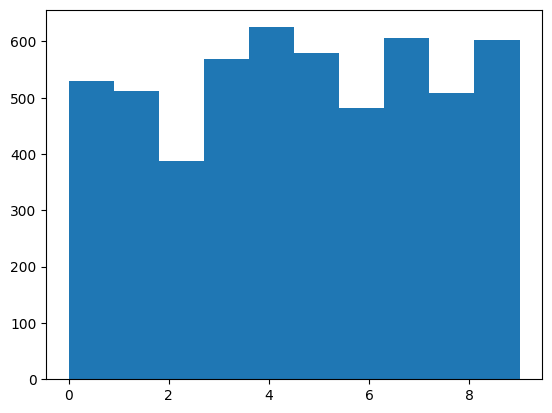

In [41]:
plt.hist(targets, bins = 10)

S2
Accuracy: [0.75047259 0.81640625 0.84754522 0.92618629 0.9824     0.90328152
 0.65696466 0.83993399 0.95284872 0.92703151] mean:  0.8603070753503335
                      precision    recall  f1-score   support

             Highway     0.8901    0.7505    0.8144       529
               River     0.9227    0.8164    0.8663       512
             Pasture     0.7371    0.8475    0.7885       387
              Forest     0.9361    0.9262    0.9311       569
         Residential     0.9192    0.9824    0.9497       625
          AnnualCrop     0.7936    0.9033    0.8449       579
       PermanentCrop     0.7488    0.6570    0.6999       481
HerbaceousVegetation     0.8290    0.8399    0.8344       606
          Industrial     0.8661    0.9528    0.9074       509
             SeaLake     0.9807    0.9270    0.9531       603

            accuracy                         0.8659      5400
           macro avg     0.8623    0.8603    0.8590      5400
        weighted avg     0.8685    0.865

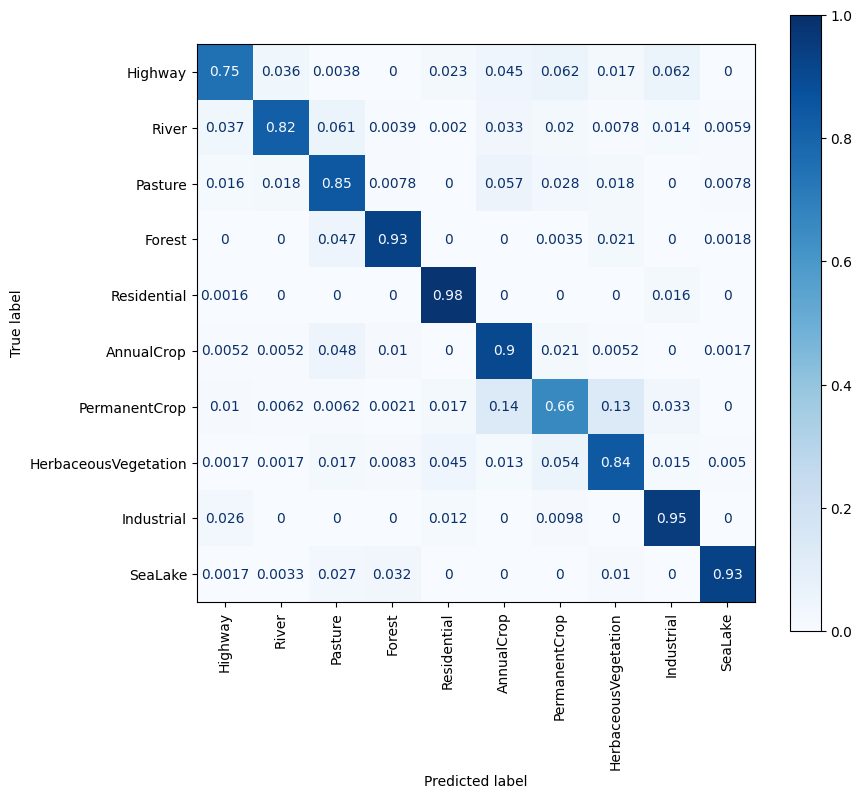

In [43]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (9,8))

cmd = ConfusionMatrixDisplay(cm, display_labels=[c.split('/')[-1] for c in handler.classes])
cmd.plot(ax=axes, cmap='Blues', xticks_rotation='vertical')
print('S2')
print('Accuracy:', cm.diagonal(), 'mean: ', cm.diagonal().mean())
print(classification_report(targets, predictions, target_names=[c.split('/')[-1] for c in handler.classes], digits=4))
axes.get_images()[0].set_clim(0, 1)
plt.show()
plt.close()